# Normalize Deaths by mobility

In [236]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import load_google_mobility, load_deaths, load_interventions, load_counties, load_google_mobility_time_series
from src.utils.dates import get_today, lag_date, date2str
from src.utils.df_utils import get_date_columns

from scipy.stats import spearmanr

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Time series data
mobility, mobility_date = load_google_mobility()
deaths, deaths_date = load_deaths(join_county_codes=False)
interventions, interventions_date = load_interventions()

# Static data
counties, counties_date = load_counties()

# Processed mobility -> time series
mobility_ts, mobility_ts_date = load_google_mobility_time_series()

In [19]:
# Ignore places with FIPS missing
deaths = deaths.dropna(axis=0, subset=['FIPS']).astype({'FIPS':'int32'})

In [3]:
FIPS = 1003
mobility_ts[mobility_ts['FIPS']==FIPS]

,FIPS,state,county,02-15,02-16,02-17,02-18,02-19,02-20,02-21,...,04-02,04-03,04-04,04-05,04-06,04-07,04-08,04-09,04-10,04-11
1,1003,AL,Baldwin County,17.0,8.0,9.0,7.0,12.0,5.0,15.0,...,-40.0,-39.0,-48.0,-55.0,-46.0,-47.0,-42.0,-41.0,-41.0,-44.0


## Preprocesses

In [234]:
## Constants
DEATH_CUTOFF = 10

In [219]:
death_dates = get_date_columns(deaths, return_dtimes=False)
death_sums = deaths[death_dates].sum(axis=1)


(array([17., 21., 31., 26., 27., 36., 28., 16., 22.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 9 Patch objects>)

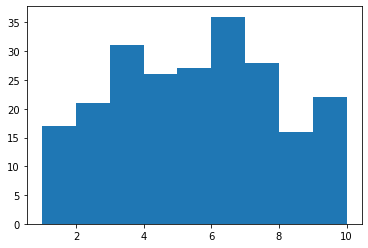

In [235]:
plt.hist(death_sums[death_sums < 10],bins=np.arange(1,DEATH_CUTOFF+1))

In [230]:
deaths = deaths[death_sums > DEATH_CUTOFF]

## Lag dates and correlate

In [267]:
# FIPS intersecion
FIPS = list(set(mobility_ts['FIPS']) & set(deaths['FIPS']))
causes = mobility_ts[mobility_ts['FIPS'].isin(FIPS)]
effects = deaths[deaths['FIPS'].isin(FIPS)]

# Sort so that FIPS align
causes = causes.sort_values(by=causes.columns.tolist()).reset_index(drop=True)
effects = effects.sort_values(by=effects.columns.tolist()).reset_index(drop=True)

In [268]:
# Get columns that are dates
cause_dates = get_date_columns(mobility_ts)
effect_dates = get_date_columns(deaths)

In [269]:
# Get start and end dates for the time series with a specified lag
day_lag = 1
start_date = max(min(cause_dates), lag_date(min(effect_dates), lag=day_lag, backwards=True))
end_date = min(max(cause_dates), lag_date(max(effect_dates), lag=day_lag, backwards=True))

In [270]:
# Get cause and effect dates in string form
cause_start = start_date
cause_end = lag_date(end_date, lag=day_lag)
effect_start = lag_date(start_date, lag=day_lag, backwards=False)
effect_end = end_date

cause_dates = [date2str(c) for c in cause_dates if (c > cause_start and c < cause_end)]
effect_dates = [date2str(c) for c in effect_dates if (c > effect_start and c < effect_end)]

In [271]:
# Adjusted time series, to aalign with given lag
cause_ts = causes[cause_dates].to_numpy()
effect_ts = effects[effect_dates].to_numpy()

In [272]:
# Transform and compute stat on two time series
def compute_pairwise_statistic(x,y=None):
    if y is None:
        y = x.iloc[1]
        x = x.iloc[0]
    x = x.to_numpy()
    y = y.to_numpy()

    # Frame mobility as decrease in mobility
    x = -x
    # Log scale deaths, allows for zeros in y
    y = np.log(y+1)
    # 1st order difference, change per each time step
    #x = x[1:] - x[:-1]
    #y = y[1:] - y[:-1]
    # Remove nans
    idx = np.logical_or(np.isnan(y), np.isnan(x))
    y = y[~idx]
    x = x[~idx]
    # Spearman rank correlation
    rho,_ = spearmanr(x,y)
    return(rho)

In [296]:
idx_heads = list(range(len(cause_dates)))
corrs = pd.concat((
    causes[cause_dates + ['FIPS']].rename({cd:i for i,cd in enumerate(cause_dates)}, axis=1),
    effects[effect_dates + ['FIPS']].rename({ed:i for i,ed in enumerate(effect_dates)}, axis=1)
    ),axis=0).groupby('FIPS').apply(lambda x: compute_pairwise_statistic(x[idx_heads]))

(array([  1.,   0.,   0.,   0.,  59., 101., 180., 191., 187., 121.]),
 array([-0.5       , -0.35603031, -0.21206062, -0.06809093,  0.07587876,
         0.21984845,  0.36381814,  0.50778783,  0.65175752,  0.79572721,
         0.9396969 ]),
 <a list of 10 Patch objects>)

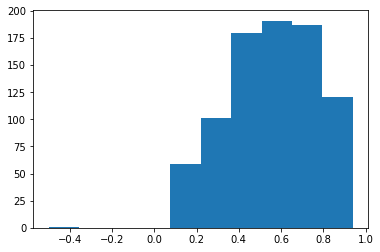

In [297]:
plt.hist(corrs)

## Loop over lags

In [ ]:
LAGS = np.arange(1,21+1)
for lag in LAGS:
    start_date = max(min(cause_dates), lag_date(min(effect_dates), lag=lag, backwards=True))
    end_date = min(max(cause_dates), lag_date(max(effect_dates), lag=lag, backwards=True))

    # Get cause and effect dates in string form
cause_start = start_date
cause_end = lag_date(end_date, lag=day_lag)
effect_start = lag_date(start_date, lag=day_lag, backwards=False)
effect_end = end_date

cause_dates = [date2str(c) for c in cause_dates if (c > cause_start and c < cause_end)]
effect_dates = [date2str(c) for c in effect_dates if (c > effect_start and c < effect_end)]